# References
## Cleveland et al. (1981)
* Antidromic stimuli applied to study the static behavior of Renshaw cells. Stimulus pulses were 200 $\mu$s wide and supramaximal for $\alpha$-axons.
* Discharge rate was measured during the 5th second after stimulation began at a given frequency.
* The data presented are all averages of a number of such measurements (usually 10) in the same cell.
* The static input-output relations for different frequencies, as shown in their Figure 5A.

## Uchiyama et al. (2003a)
* Synaptic swellings are indications of the strength of an $\alpha$ motoneuron's synaptic inputs to other spinal neurons. The proportions used are those reported by Cullheim and Kellerth (1978), in which FF number is ca. 1.8 the FR number and ca. 2.2 the S number.

# Parameters adjusted
* Connections and conductances

# Considerations
* Variability is not expected in the model and simulation results supported this. Therefore averages like those described in Cleveland et al. (1981) for each cell will not be carried out and the curve fitting can be done directly from data points obtained in a single simulation.
* Since 5 s is too much to simulate, the adaptation time is reduced and the plot shown is to assure the cell have adapted after the adopted value.
* Figure 5B (Cleveland et al., 1981) can also be a good direction, but I am not expecting too much variation.
* The authors do not report information about population (e.g. distance, type) so I decided to choose random Renshaw cells to take the mean of fitted curves, just like they did.
* Deafferentation resulted in no spontaneous responses.

In [1]:
import sys
import time

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import scipy.optimize

In [2]:
def langmuir(f, c, k):
    return c*f/(k + f)

In [3]:
tmin = 500
simDuration_ms = 1000
availableRCs = range(1, 601)
recordedRCs = np.random.choice(availableRCs, size=24, replace=False)
print 'Recorded RCs #' + str(recordedRCs)
freqs = [x for x in range(10, 80, 10)]
firingRates = [[0]*len(freqs) for i in range(len(recordedRCs))]
for i, recordedRC in enumerate(recordedRCs):
    for j, freq in enumerate(freqs):
        unitNumber = []
        spikeInstant = []
        filename = 'output'+str(freq)+'.dat'
        f = open(filename, 'r')
        lines = f.readlines()
        for line in lines:
            spikeInstant.append(float(line.split()[0]))
            unitNumber.append(int(float(line.split()[1])))

    # This to automate
    #     if recordedRC is None:
    #         availableRCs = max(unitNumber)
    #         recordedRC = np.random.choice(availableRCs)
    #         print 'Recorded RC #' + str(recordedRC)

        RCSpikeInstants = [y for x, y in enumerate(spikeInstant) if unitNumber[x]==recordedRC]
        numberOfSpikes = len([x for x in RCSpikeInstants if x>tmin])
        firingRates[i][j] = float(numberOfSpikes)*1e3/(simDuration_ms-tmin)

Recorded RCs #[186 521 321 231 449  77 447 149 194 391 209 338 533  40 404 544 497 445
 383 448  98 267 453 548]


<IPython.core.display.Javascript object>


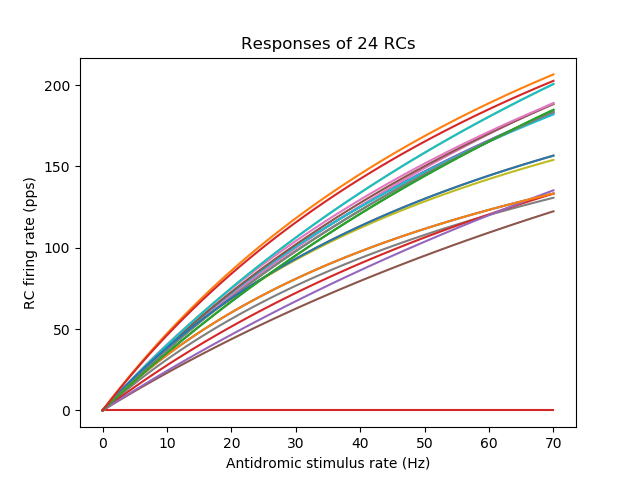

In [5]:
cs = []
plt.figure()
for firingRate in firingRates:
    # Curve fitting
    try:
        # maxfev is passed to least method square and avoids runtime error
        fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, firingRate, bounds=(0, np.inf), maxfev=2000)
        cs.append(fit_params[0])
    except RuntimeError:
        print 'Least square method failed. The value was ignored'
        
    fittedLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)
    plt.plot(np.linspace(0, 70, 100), fittedLangmuir)
plt.title('Responses of 24 RCs')
plt.xlabel('Antidromic stimulus rate (Hz)')
plt.ylabel('RC firing rate (pps)')
plt.show()

<IPython.core.display.Javascript object>


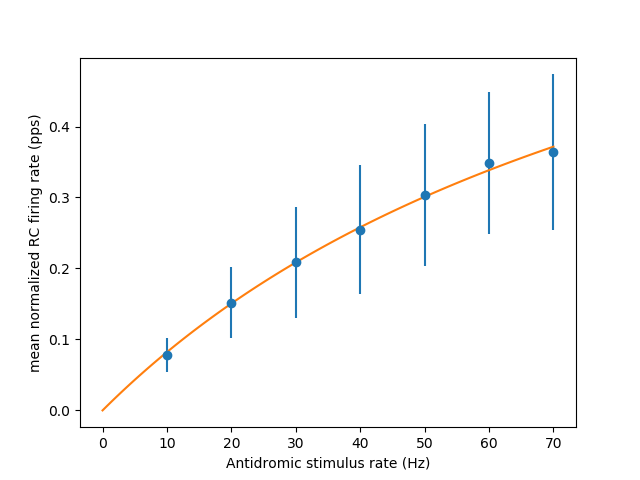

In [6]:
# Langmuir curves averaging
npRates = np.array(firingRates)

# Normalization
for i, c in enumerate(cs):
    npRates[i,:] = npRates[i,:]/c
    
# Statistics
numbCurves = npRates.shape[0]
aveRate = np.sum(npRates, axis=0)/numbCurves
stdRate = np.std(npRates, axis=0)

fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, aveRate, bounds=(0, np.inf), maxfev=2000)
aveLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)

# Plots
plt.figure()
plt.errorbar(freqs, aveRate, stdRate, linestyle='None', marker='o')
plt.plot(np.linspace(0, 70, 100), aveLangmuir, label='Langmuir fitted to mean')
plt.xlabel('Antidromic stimulus rate (Hz)')
plt.ylabel('mean normalized RC firing rate (pps)')
plt.show()

<IPython.core.display.Javascript object>


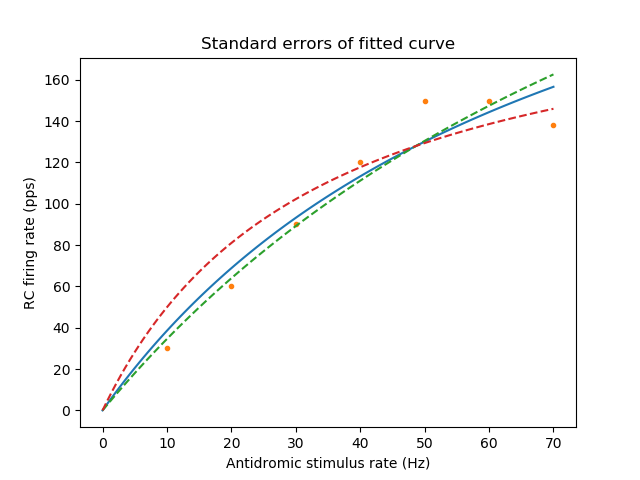

In [7]:
# Checking some RCs
choosenRC = 20
plt.figure()
fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, firingRates[choosenRC], bounds=(0, np.inf))
# Standar Errors
SE1 = np.sqrt(np.diag(pcov))[0]
SE2 = np.sqrt(np.diag(pcov))[1]
fittedLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)
plt.plot(np.linspace(0, 70, 100), fittedLangmuir)
plt.plot(freqs, firingRates[choosenRC], '.')
plt.plot(np.linspace(0, 70, 100), langmuir(np.linspace(0, 70, 100), fit_params[0]+SE1, fit_params[1]+SE2), '--')
plt.plot(np.linspace(0, 70, 100), langmuir(np.linspace(0, 70, 100), fit_params[0]-SE1, fit_params[1]-SE2), '--')
plt.title('Standard errors of fitted curve')
plt.xlabel('Antidromic stimulus rate (Hz)')
plt.ylabel('RC firing rate (pps)')
plt.show()